In [9]:
import numpy as np

m = np.array([[1, 3, 5], [6, 3, 0], [10, 12, 3]])
m = np.sort(m, axis=1)
m[:,-1] - m[:,-2], np.argsort(m[:,-1] - m[:,-2])

(array([2, 3, 2]), array([0, 2, 1]))

In [1]:
def get_data(file_name):
    
    f_dim = 0
    n_doc = 0

    ind, val, class_doc = [], [], []

    with open(file_name, 'r') as f:
        for line in f:
            n_doc = n_doc + 1
            line = line.replace(': .', ':0.')
            items = line.split()
            for item in items:
                
                sep_ind = item.find(':')
                if sep_ind != -1:
                    
                    n_feature = int(item[0:sep_ind])
                    
                    v_feature = float(item[sep_ind+1:len(item)])
                    
                    ind.append([n_doc-1, n_feature-1])
                    val.append(v_feature)
                    
                    if n_feature > f_dim:
                        f_dim = n_feature
                else:
                    class_doc.append(int(item))
                
    data_shape = [n_doc,f_dim]
        
    f.close()
    
    return ind, val, np.array(class_doc), data_shape

def make_csr(ind, val, data_shape):
    row, col = zip(*ind)
    sparse_matrix = sp.csr_matrix((np.array(val), (np.array(row),np.array(col))),shape=(data_shape[0],data_shape[1]))
    return sparse_matrix

# protein dataset

In [2]:
import numpy as np
import pandas as pd
from data_gen import *
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
%load_ext autoreload
%autoreload 1
%aimport zero_shot_active_learning

data = pd.read_csv("../../../Datasets/protein/mice_protein_expression.csv").dropna().drop(['Unnamed: 0'], axis=1)
y = data.pop('class').values
y[y == 'c-CS-s'] = 0
y[y == 'c-CS-m'] = 1
y[y == 'c-SC-s'] = 2
y[y == 'c-SC-m'] = 3
y[y == 't-CS-s'] = 4
y[y == 't-CS-m'] = 5
y[y == 't-SC-s'] = 6
y[y == 't-SC-m'] = 7
y = y.astype(int)
X = data.values
X = normalize(X, norm='max',axis=0)

loader = np.load('../../obj/protein.npz')
ids_train = loader['train']
ids_test = loader['test']


loader = np.load('../../obj/protein_density.npz')
density = loader['density']


loader = np.load('../../obj/protein_dist.npz')
dist = loader['distance']


loader = np.load('../../obj/protein_idx.npz')
idx = loader['indices']

np.unique(y, return_counts=True), X.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


((array([0, 1, 2, 3, 4, 5, 6, 7]),
  array([135, 150, 135, 150, 105, 135, 135, 135])),
 (1080, 77))

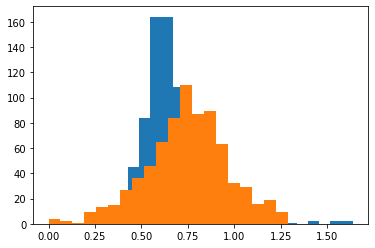

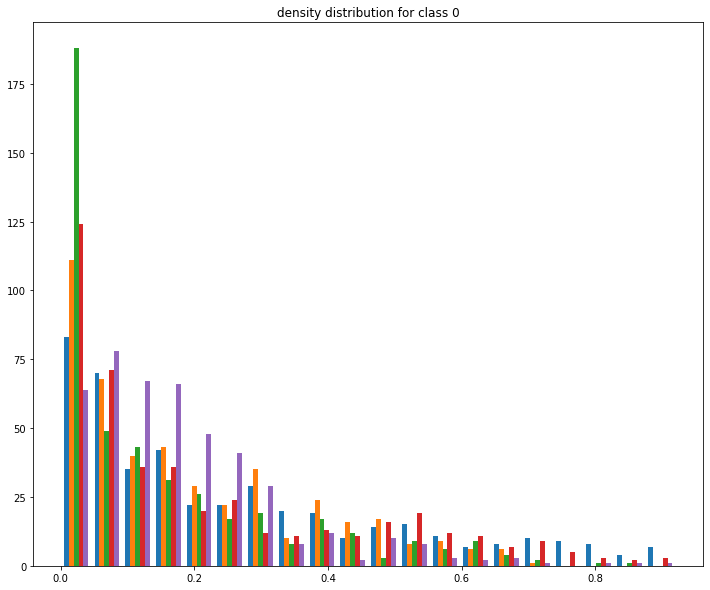

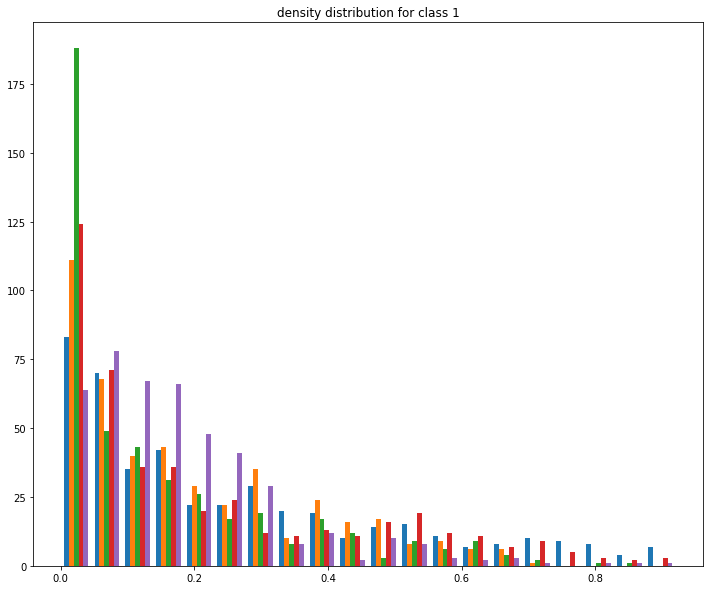

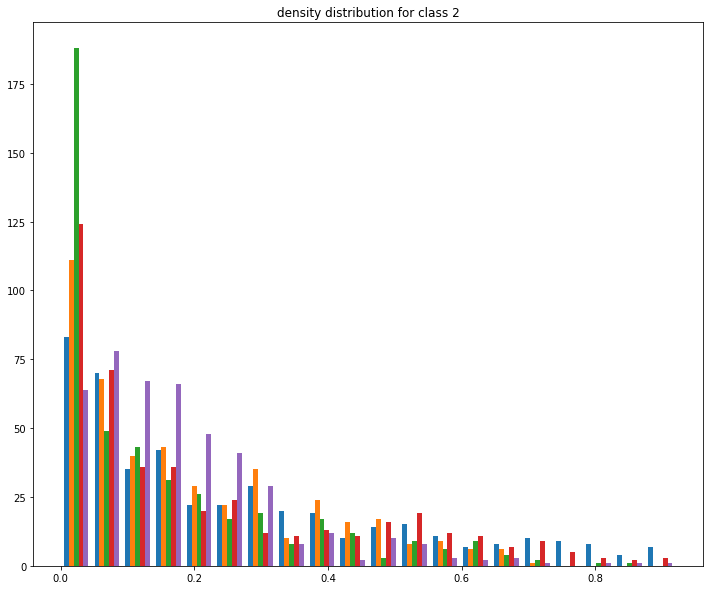

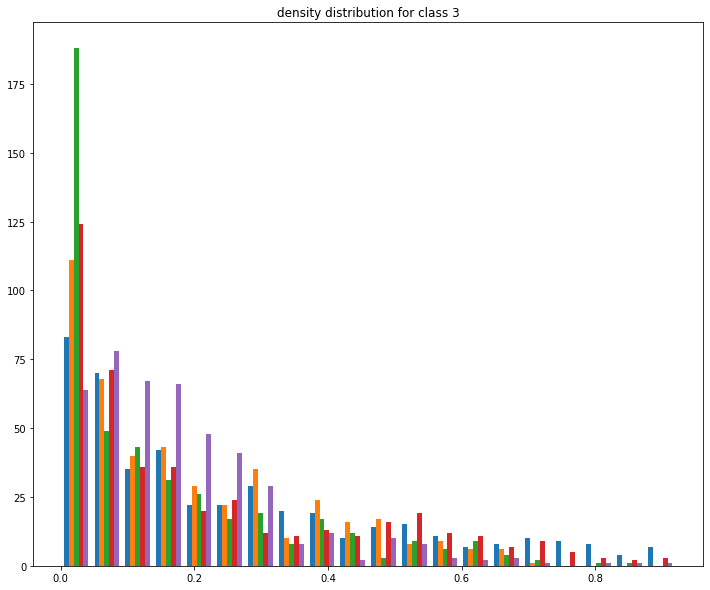

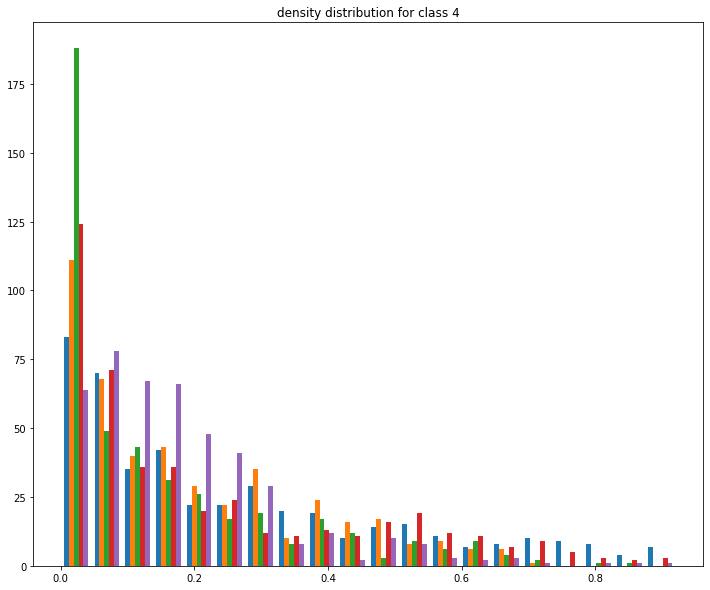

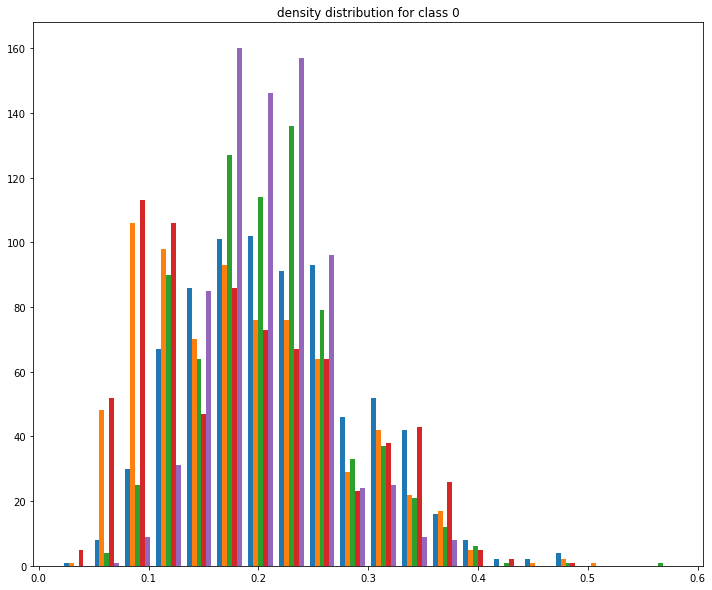

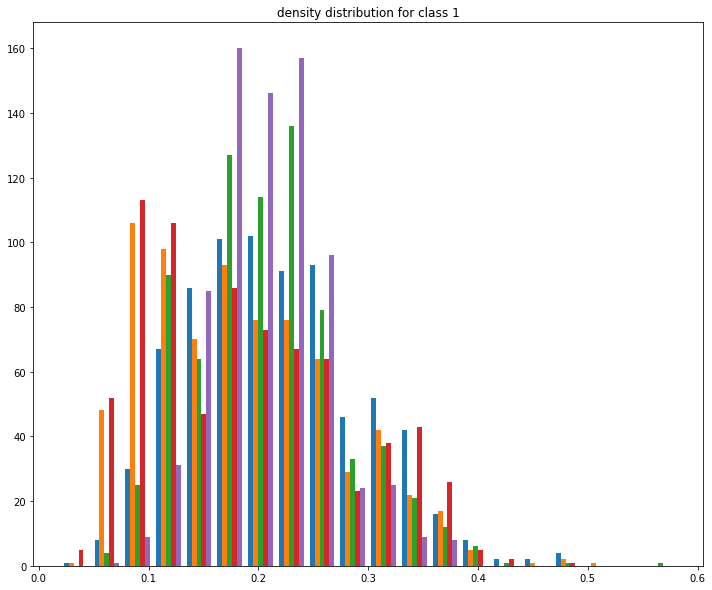

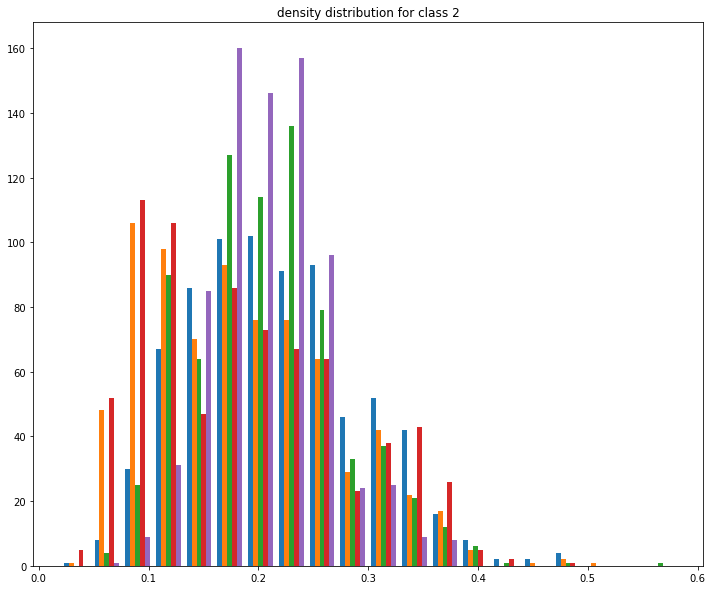

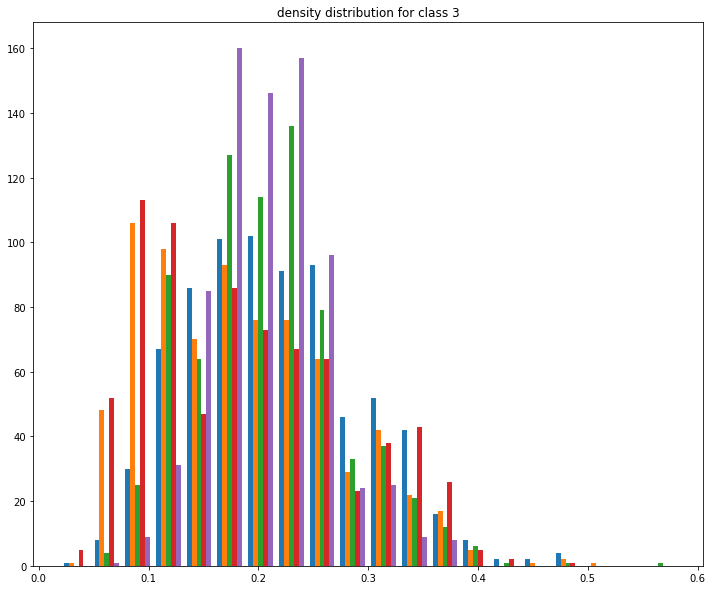

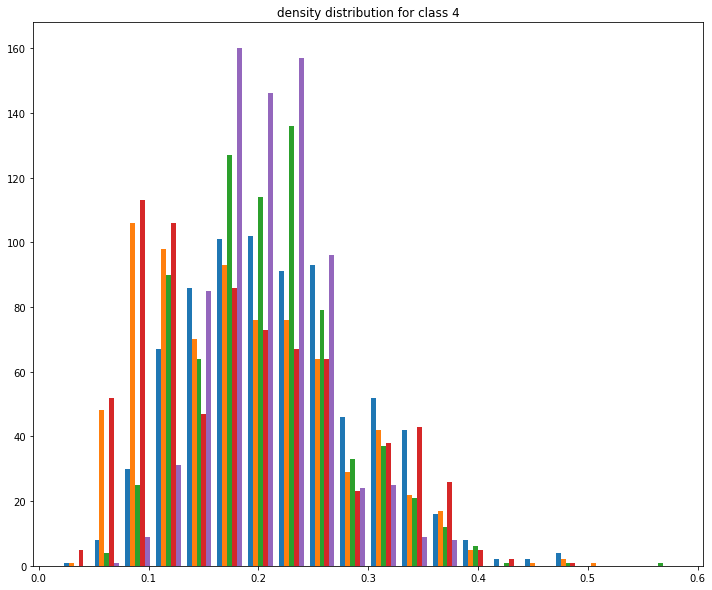

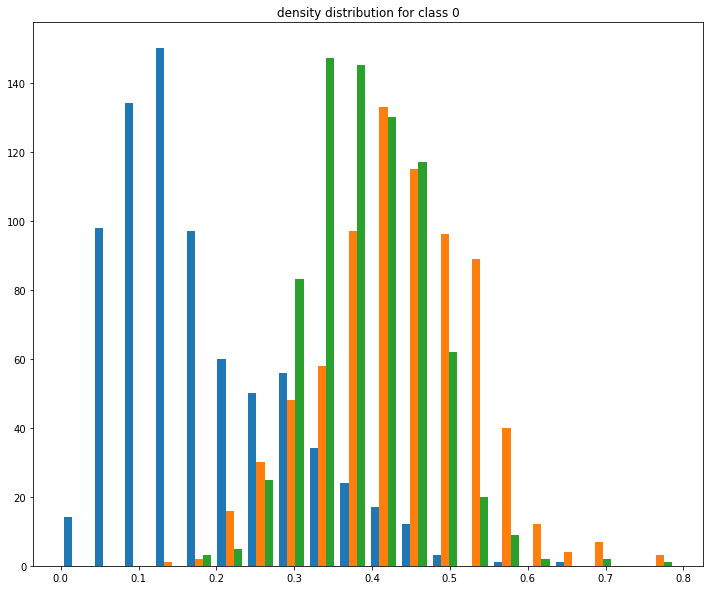

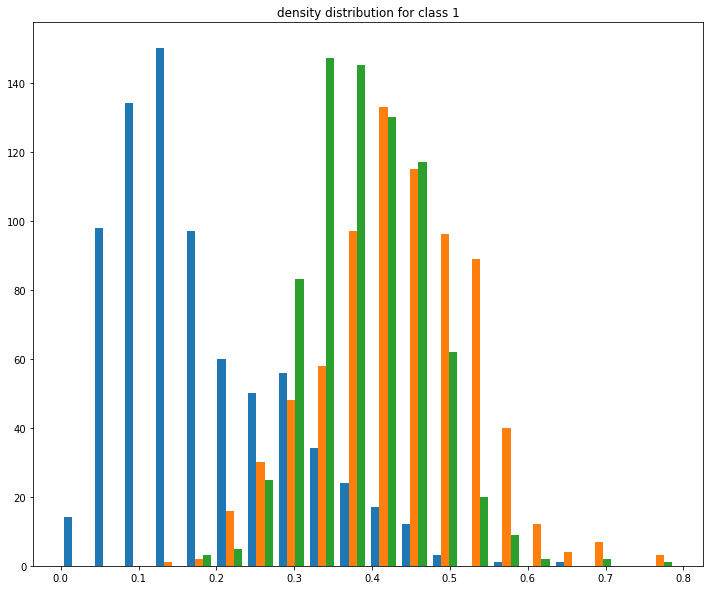

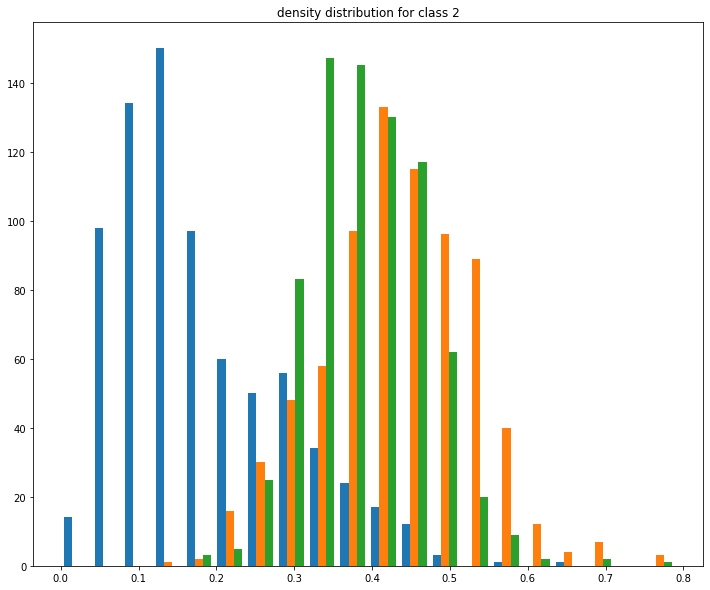

## -- Budget k =  5
TCAL : mean=0.45608, std=0.00000
Seed set : mean=0.28159, std=0.00000
Random : mean=0.18313, std=0.00000


In [15]:
from math import tan
import matplotlib.pyplot as plt
from zero_shot_active_learning import TCAL
from modAL.models import ActiveLearner
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling


def Agent(X_train, y_train, X_pool, y_pool, n_queries=5, size=20, X_test=None, y_test=None):
    n_queries = min(n_queries, int(len(y_pool)/size))
    if n_queries == 0 and len(y_pool) > 0:
        n_queries = 1
        size = len(y_pool)

    estim = RandomForestClassifier(random_state=2020, n_jobs=-1)
    learner = ActiveLearner(estimator=estim, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)
    probas = learner.predict_proba(X_pool)
    for i in range(probas.shape[1]):
        fig, ax = plt.subplots(figsize=(12, 10))
        bin, h, _ = plt.hist(probas, bins=20)
        plt.title('density distribution for class '+str(i))
        plt.show()
    
    return learner, n_queries, size

radian = tan(0.45)
distance_ = dist[0] - np.min(dist[0])
density_ = density[0] - np.min(density[0])
bin, h, _ = plt.hist(np.average(distance_, axis=1),bins=20)  
m_dist = h[np.argmax(bin)]
bin, h, _ = plt.hist(density_, bins=20)
m_densit = h[np.argmax(bin)]
bais = (m_dist + radian*m_densit)/radian

for k in [5]:
    acc_r = []
    acc_b = []
    acc_s = []
    
    for r in range(1):
        m = TCAL(density=density[r], dist=dist[r], idx=idx[r], y=y[ids_train[r]], m = 1, 
                bais=bais, rad=radian, n_clusters=k)
        train_x, train_y = m.fit(X[ids_train[r],:], y[ids_train[r]])
        X_pool, y_pool = X[ids_train[r],:][m.labels_ == -1], y[ids_train[r]][m.labels_ == -1]
        
        # TCAL set classif
        clf, n_queries, size = Agent(train_x, train_y, X_pool, y_pool, X_test=X[ids_test[r],:], y_test=y[ids_test[r]]) 
        acc_b.append(balanced_accuracy_score(y[ids_test[r]], clf.predict(X[ids_test[r],:])))
        
        # Seed set classif
        X_pool, y_pool = np.delete(X[ids_train[r],:], m.seed_ind, axis=0), np.delete(y[ids_train[r]], m.seed_ind)
        clf, _, _ = Agent(X[ids_train[r],:][m.seed_ind,:], y[ids_train[r]][m.seed_ind], X_pool, y_pool, n_queries, size
                            , X[ids_test[r],:], y[ids_test[r]]) 
        acc_s.append(balanced_accuracy_score(y[ids_test[r]], clf.predict(X[ids_test[r],:])))

        # Random set classif
        clf, _, _ = Agent(X[ids_train[r],:][:k,], y[ids_train[r]][:k], X_pool, 
                y_pool, n_queries, size, X[ids_test[r],:], y[ids_test[r]])
        acc_r.append(balanced_accuracy_score(y[ids_test[r]], clf.predict(X[ids_test[r],:])))

    print('## -- Budget k = ', k)
    print('TCAL : mean=%.5f, std=%.5f' % (np.mean(acc_b), np.std(acc_b)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

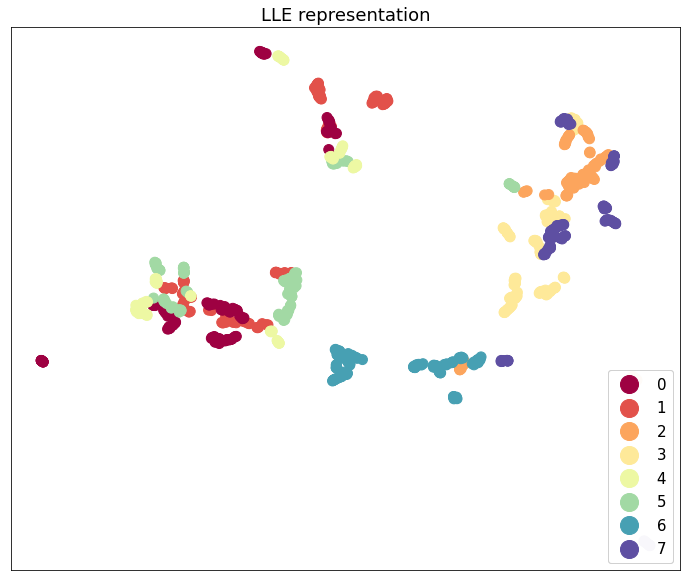

In [4]:
import umap
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt

#embedding = LocallyLinearEmbedding(n_components=2)
embedding = umap.UMAP(random_state=2020)
X_transformed = embedding.fit_transform(X)

fig, ax = plt.subplots(figsize=(12, 10))
scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap="Spectral", s=100)
plt.setp(ax, xticks=[], yticks=[])
plt.title("LLE representation", fontsize=18)
legend2 = ax.legend(*scatter.legend_elements(), loc="lower right", prop={'size': 15} , markerscale=3.)
ax.add_artist(legend2)
plt.show()

In [3]:
from zero_shot_active_learning import TCAL

for i in range(20):
    ids_train = Datasets.load_obj('protein_train_'+str(i))
    ids_test = Datasets.load_obj('protein_test_'+str(i))
    m = TCAL(rad=.29, y=y[ids_train], m=.48, bais=2.86, n_clusters=14)
    m.fit(X[ids_train,:])
    unique, counts = np.unique(m.labels_, return_counts=True)
    print(unique, counts)
    print('Isolated points : ', np.sum(counts ==1))

FileNotFoundError: [Errno 2] No such file or directory: '../../obj/protein_train_0.pkl'

## Save 20 random splits

In [45]:
from sklearn.model_selection import train_test_split

for i in range(20):
    print('saving split : ', i)
    id_train, id_test = train_test_split(np.arange(len(y)), test_size=.3)
    Datasets.save_obj(id_train, 'protein_train_'+str(i))
    Datasets.save_obj(id_test, 'protein_test_'+str(i))

saving split :  0
saving split :  1
saving split :  2
saving split :  3
saving split :  4
saving split :  5
saving split :  6
saving split :  7
saving split :  8
saving split :  9
saving split :  10
saving split :  11
saving split :  12
saving split :  13
saving split :  14
saving split :  15
saving split :  16
saving split :  17
saving split :  18
saving split :  19


# All trainning set

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

acc_b = []
acc_s = []
for r in range(20):
    ids_train = Datasets.load_obj('protein_train_'+str(r))
    ids_test = Datasets.load_obj('protein_test_'+str(r))

    # Linear SVM
    clf = SGDClassifier(random_state=2020)
    clf.fit(X[ids_train,:], y[ids_train])
    acc_b.append(clf.score(X[ids_test,:], y[ids_test]))

    # Random forest
    clf = RandomForestClassifier(n_estimators=200, random_state=2020, n_jobs=-1)
    clf.fit(X[ids_train,:], y[ids_train])
    acc_s.append(clf.score(X[ids_test,:], y[ids_test]))

print('Linear SVM : mean=%.5f, std=%.5f' % (np.mean(acc_b), np.std(acc_b)))
print('Random forest : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))

Linear SVM : mean=0.82423, std=0.08170
Random forest : mean=0.98719, std=0.00726


# Sample importance with loo loss

In [10]:
import data_gen
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

loo = LeaveOneOut()
scores = []
for train_index, test_index in loo.split(X):
    X_train, y_train = X[train_index], y[train_index]
    clf = SGDClassifier(random_state=2020)
    scores.append(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
Datasets.save_obj(scores, 'protein_scores')

# Rank score

In [2]:
from zero_shot_active_learning import BMeans
from zero_shot_active_learning import TCAL 
import numpy as np

rank = np.load('../../obj/loo_protein.npz')

for k in [5, 10]:
    acc_s = []
    acc_t = []
    acc_r = []
    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        acc_r.append(np.mean(rank[ids_train][:k]))
        m = BMeans(n_clusters=k, rank=rank[ids_train], verbose=False)
        m.fit(X[ids_train,:], y[ids_train])
        acc_s.append(m.rank_score())
        
        t = TCAL(rad=.29, y=y[ids_train], m=.48, bais=2.86, n_clusters=k, rank=rank[ids_train])
        t.fit(X[ids_train,:])
        acc_t.append(t.rank_score())
    print('## -- Budget k = ', k)
    print('BMeans : mean=%.5f' % np.mean(acc_s))
    print('TCAL : mean=%.5f' % np.mean(acc_t))
    print('Random : mean=%.5f' % np.mean(acc_r))

FileNotFoundError: [Errno 2] No such file or directory: '../../obj/protein_train_0.pkl'

# Active learning

In [9]:
from sklearn.ensemble import RandomForestClassifier
from modAL.uncertainty import uncertainty_sampling
from modAL.models import ActiveLearner

def Agent(X_train, y_train, X_pool, y_pool):
    N_QUERIES = min(20, len(y_pool))
    
    learner = ActiveLearner(estimator=RandomForestClassifier(random_state=2020, n_jobs=-1), 
                            query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)
    for index in range(N_QUERIES):
        query_index, query_instance = learner.query(X_pool)
        
        # Teach our ActiveLearner model the record it has requested.
        X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
        learner.teach(X=X, y=y)
        
        # Remove the queried instance from the unlabeled pool.
        X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
        
    return learner

In [12]:
from zero_shot_active_learning import TCAL

for k in [5]:
    acc_r = []
    acc_t = []
    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        
        # TCAL
        t = TCAL(rad=.29, y=y[ids_train], m=.48, bais=2.86, n_clusters=k)
        train_x, train_y = t.fit(X[ids_train,:])
        X_pool, y_pool = X[ids_train,][t.labels_ == -1], y[ids_train][t.labels_ == -1] 
        clf = Agent(train_x, train_y, X_pool, y_pool)
        acc_t.append((clf.score(X[ids_test,:], y[ids_test])))
        
        # Random set classif
        X_pool, y_pool = X[ids_train,:][k:,], y[ids_train][k:]
        clf = Agent(X[ids_train,:][:k,], y[ids_train][:k], X_pool, y_pool)
        acc_r.append((clf.score(X[ids_test,:], y[ids_test])))
        
    print('## -- Budget k = ', k)
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))
    print('TCAL : mean=%.5f, std=%.5f' % (np.mean(acc_t), np.std(acc_t)))

## -- Budget k =  5
Random : mean=0.45494, std=0.03458
TCAL : mean=0.38272, std=0.05289


# Bmeans

In [2]:
from zero_shot_active_learning import BMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np

for k in [5, 10]:
    acc_r = []
    acc_b = []
    acc_s = []
    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        m = BMeans(n_clusters=k, verbose=False)
        m.fit(X[ids_train,:], y[ids_train])
        train_x = X[ids_train,:][m.labels_ != -1,]
        train_y = m.labels_[m.labels_ != -1]
        
        # Bmeans set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_b.append(clf.score(X[ids_test,:], y[ids_test]))
        
        # Seed set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test,:], y[ids_test]))
        
        # Random set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train,:][:k,], y[ids_train][:k])
        acc_r.append((clf.score(X[ids_test,:], y[ids_test])))
    print('## -- Budget k = ', k)
    print('BMeans : mean=%.5f, std=%.5f' % (np.mean(acc_b), np.std(acc_b)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

## -- Budget k =  5
BMeans : mean=0.26219, std=0.03438
Seed set : mean=0.19306, std=0.06277
Random : mean=0.18781, std=0.04491
## -- Budget k =  10
BMeans : mean=0.31204, std=0.03882
Seed set : mean=0.24414, std=0.06054
Random : mean=0.24290, std=0.04956


In [3]:
from zero_shot_active_learning import BMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

for k in [5, 10]:
    acc_r = []
    acc_b = []
    acc_s = []
    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        m = BMeans(n_clusters=k, verbose=False)
        m.fit(X[ids_train,:], y[ids_train])
        train_x = X[ids_train,:][m.labels_ != -1,]
        train_y = m.labels_[m.labels_ != -1]
        
        # Bmeans set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(train_x, train_y)
        acc_b.append(clf.score(X[ids_test,:], y[ids_test]))
        
        # Seed set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test,:], y[ids_test]))
        
        # Random set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(X[ids_train,:][:k,], y[ids_train][:k])
        acc_r.append((clf.score(X[ids_test,:], y[ids_test])))
    print('## -- Budget k = ', k)
    print('BMeans : mean=%.5f, std=%.5f' % (np.mean(acc_b), np.std(acc_b)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

## -- Budget k =  5
BMeans : mean=0.26157, std=0.03222
Seed set : mean=0.27407, std=0.04068
Random : mean=0.18287, std=0.04140
## -- Budget k =  10
BMeans : mean=0.31327, std=0.03208
Seed set : mean=0.31019, std=0.03848
Random : mean=0.26327, std=0.04551


# Intersection

In [9]:
from zero_shot_active_learning import BMeans
from zero_shot_active_learning import TCAL 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model
import numpy as np

for k in [5, 10]:
    acc_tcal = []
    acc_bmeans = []
    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        b = BMeans(n_clusters=k, verbose=False)
        b.fit(X[ids_train,:], y[ids_train])
        t = TCAL(rad=.29, y=y[ids_train], m=.48, bais=2.86, n_clusters=k)
        _, train_y = t.fit(X[ids_train,:])
        acc_tcal.append(accuracy_score(y[ids_train][t.labels_ != -1], train_y))
        acc_bmeans.append(accuracy_score(y[ids_train][t.labels_ != -1], b.labels_[t.labels_ != -1]))
    print('## -- Budget k = ', k)
    print('BMeans accuracy on intersection: mean=%.5f, std=%.5f' % (np.mean(acc_bmeans), np.std(acc_bmeans)))
    print('TCAL accuracy on intersection : mean=%.5f, std=%.5f' % (np.mean(acc_tcal), np.std(acc_tcal)))

## -- Budget k =  5
BMeans accuracy on intersection: mean=0.26133, std=0.04644
TCAL accuracy on intersection : mean=0.46052, std=0.06945
## -- Budget k =  10
BMeans accuracy on intersection: mean=0.35238, std=0.03853
TCAL accuracy on intersection : mean=0.49719, std=0.04526


# TCAL

In [3]:
from zero_shot_active_learning import TCAL 
from sklearn.ensemble import RandomForestClassifier
import numpy as np

for k in [5, 10]:
    acc_r = []
    acc_t = []
    acc_p = []
    acc_s = []

    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        m = TCAL(bais=2.86, y=y[ids_train], m=.48, rad=.29, n_clusters=k)
        train_x, train_y = m.fit(X[ids_train,:])

        # TCAL set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(train_x, train_y)
        acc_t.append(clf.score(X[ids_test,:], y[ids_test]))
        
        # TCAL+PROP set classif
        acc_p.append(m.model.score(X[ids_test,:], y[ids_test]))
        
        # Seed set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test,:], y[ids_test]))

        # Random set classif
        clf = RandomForestClassifier(random_state=2020, n_jobs=-1)
        clf.fit(X[ids_train,:][:k,], y[ids_train][:k])
        acc_r.append((clf.score(X[ids_test,:], y[ids_test])))
    print('## -- Budget k = ', k)
    print('TCAL : mean=%.5f, std=%.5f' % (np.mean(acc_t), np.std(acc_t)))
    print('TCAL+PROP : mean=%.5f, std=%.5f' % (np.mean(acc_p), np.std(acc_p)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normal

## -- Budget k =  5
TCAL : mean=0.31636, std=0.06429
TCAL+PROP : mean=0.32253, std=0.06414
Seed set : mean=0.24630, std=0.04646
Random : mean=0.18287, std=0.04140


/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/lies/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


## -- Budget k =  10
TCAL : mean=0.43256, std=0.05149
TCAL+PROP : mean=0.45679, std=0.05552
Seed set : mean=0.30633, std=0.05014
Random : mean=0.26327, std=0.04551


## -- tau=0

In [4]:
from zero_shot_active_learning import TCAL 
from sklearn import linear_model

for k in [5, 10]:
    acc_r = []
    acc_t = []
    acc_s = []

    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        m = TCAL(rad=.29, tau=0, y=y[ids_train], m=.48, bais=2.86, n_clusters=k)
        train_x, train_y = m.fit(X[ids_train,:])

        # TCAL set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_t.append(clf.score(X[ids_test,:], y[ids_test]))

        # Seed set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test,:], y[ids_test]))

        # Random set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train,:][:k,], y[ids_train][:k])
        acc_r.append((clf.score(X[ids_test,:], y[ids_test])))
    print('## -- Budget k = ', k)
    print('TCAL : mean=%.5f, std=%.5f' % (np.mean(acc_t), np.std(acc_t)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

## -- Budget k =  5
TCAL : mean=0.29784, std=0.04859
Seed set : mean=0.19630, std=0.07074
Random : mean=0.19167, std=0.05920
## -- Budget k =  10
TCAL : mean=0.40170, std=0.07333
Seed set : mean=0.23843, std=0.08046
Random : mean=0.21157, std=0.06714


In [3]:
from zero_shot_active_learning import TCAL 
from sklearn import linear_model
import numpy as np

for k in [5, 10]:
    acc_r = []
    acc_t = []
    acc_p = []
    acc_s = []

    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        m = TCAL(bais=2.86, y=y[ids_train], m=.48, rad=.29, n_clusters=k)
        train_x, train_y = m.fit(X[ids_train,:])

        # TCAL set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_t.append(clf.score(X[ids_test,:], y[ids_test]))
        
        # TCAL+PROP set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train,:], m.model.predict(X[ids_train,:]))
        acc_p.append(clf.score(X[ids_test,:], y[ids_test]))
        
        # Seed set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test,:], y[ids_test]))

        # Random set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train,:][:k,], y[ids_train][:k])
        acc_r.append((clf.score(X[ids_test,:], y[ids_test])))
    print('## -- Budget k = ', k)
    print('TCAL : mean=%.5f, std=%.5f' % (np.mean(acc_t), np.std(acc_t)))
    print('TCAL+PROP : mean=%.5f, std=%.5f' % (np.mean(acc_p), np.std(acc_p)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

## -- Budget k =  5
TCAL : mean=0.32361, std=0.06023
TCAL+PROP : mean=0.31265, std=0.06388
Seed set : mean=0.23071, std=0.05712
Random : mean=0.18781, std=0.04491
## -- Budget k =  10
TCAL : mean=0.44275, std=0.06302
TCAL+PROP : mean=0.41667, std=0.06706
Seed set : mean=0.20602, std=0.06140
Random : mean=0.24290, std=0.04956


## -- tau estimated

In [49]:
from zero_shot_active_learning import TCAL 
from sklearn import linear_model
import numpy as np

for k in [5, 10]:
    acc_r = []
    acc_t = []
    acc_s = []

    for r in range(20):
        ids_train = Datasets.load_obj('protein_train_'+str(r))
        ids_test = Datasets.load_obj('protein_test_'+str(r))
        m = TCAL(rad=.29, y=y[ids_train], m=.48, bais=2.86, n_clusters=k)
        train_x, train_y = m.fit(X[ids_train,:])

        # TCAL set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(train_x, train_y)
        acc_t.append(clf.score(X[ids_test,:], y[ids_test]))

        # Seed set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(m.seed[0], m.seed[1])
        acc_s.append(clf.score(X[ids_test,:], y[ids_test]))

        # Random set classif
        clf = linear_model.SGDClassifier(random_state=2020)
        clf.fit(X[ids_train,:][:m.n_clusters,], y[ids_train][:m.n_clusters])
        acc_r.append((clf.score(X[ids_test,:], y[ids_test])))
    print('## -- Budget k = ', k)
    print('TCAL : mean=%.5f, std=%.5f' % (np.mean(acc_t), np.std(acc_t)))
    print('Seed set : mean=%.5f, std=%.5f' % (np.mean(acc_s), np.std(acc_s)))
    print('Random : mean=%.5f, std=%.5f' % (np.mean(acc_r), np.std(acc_r)))

## -- Budget k =  5
TCAL : mean=0.31605, std=0.06141
Seed set : mean=0.23071, std=0.05712
Random : mean=0.18781, std=0.04491
## -- Budget k =  10
TCAL : mean=0.44969, std=0.05986
Seed set : mean=0.20602, std=0.06140
Random : mean=0.24815, std=0.04988


## Save 20 random split pre-computed data

In [2]:
from sklearn.neighbors import NearestNeighbors

ids_train = []
ids_test = []
dists_ = []
idxs_ = []
density_ = []
for i in range(20):
    print(i)
    id_train, id_test = train_test_split(np.arange(len(y)), test_size=.3)
    ids_train.append(id_train)
    ids_test.append(id_test)
    num_pts = X[id_train,:].shape[0]
    nbrs = NearestNeighbors(n_neighbors=int(num_pts / 10), n_jobs=-1).fit(X[id_train,:])
    dist_, idx_ = nbrs.kneighbors()
    dists_.append(dist_)
    idxs_.append(idx_)
    density_.append(1/np.sqrt(np.mean(np.square(dist_), axis=1)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


###### split  0  ######
max occurence for distance:  0.5463235771530155
min :  0.0  max :  1.84023133461726


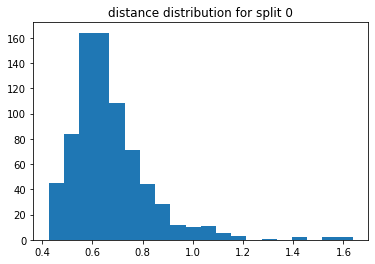

max occurence for density:  0.7073522185267276
min :  0.0  max :  1.2860949427758683


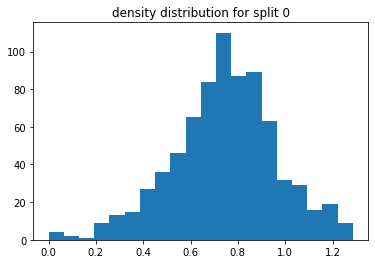

In [12]:
import matplotlib.pyplot as plt

for i in range(1):
    print('###### split ',i,' ######')
    distance = dist[i] - np.min(dist[i])
    density = density[i] - np.min(density[i])
    bin, h, _ = plt.hist(np.average(distance, axis=1),bins=20)
    print('max occurence for distance: ', h[np.argmax(bin)])
    print('min : ', np.min(distance), ' max : ', np.max(distance))
    plt.title('distance distribution for split '+str(i))
    plt.show()
    bin, h, _ = plt.hist(density, bins=20)
    print('max occurence for density: ', h[np.argmax(bin)])
    print('min : ', np.min(density), ' max : ', np.max(density))
    plt.title('density distribution for split '+str(i))
    plt.show()

In [4]:
lignes

['==== m =  1  radian =  0.1  bais =  0.1  ====\n',
 'dataset :  statlog\n',
 'estimator :  randomforest\n',
 '## -- Budget k =  5\n',
 'TCAL : mean=0.21188, std=0.04042\n',
 'Seed set : mean=0.38298, std=0.05964\n',
 '## -- Budget k =  10\n',
 'TCAL : mean=0.29915, std=0.08341\n',
 'Seed set : mean=0.51911, std=0.06785\n',
 '## -- Budget k =  20\n',
 'TCAL : mean=0.38309, std=0.09840\n',
 'Seed set : mean=0.60008, std=0.07112\n',
 '==== m =  1  radian =  0.1  bais =  0.2  ====\n',
 'dataset :  statlog\n',
 'estimator :  randomforest\n',
 '## -- Budget k =  5\n',
 'TCAL : mean=0.21188, std=0.04042\n',
 'Seed set : mean=0.38298, std=0.05964\n',
 '## -- Budget k =  10\n',
 'TCAL : mean=0.29915, std=0.08341\n',
 'Seed set : mean=0.51911, std=0.06785\n',
 '## -- Budget k =  20\n',
 'TCAL : mean=0.38309, std=0.09840\n',
 'Seed set : mean=0.60008, std=0.07112\n',
 '==== m =  1  radian =  0.1  bais =  0.3  ====\n',
 'dataset :  statlog\n',
 'estimator :  randomforest\n',
 '## -- Budget k =  5

In [15]:
f = open('protein_grid', 'r')
lignes = f.readlines()
m = 0
for i in range(len(lignes)):
    if lignes[i][0] == 'T' and lignes[i-1] == "## -- Budget k =  5\n":
        if float(lignes[i].split(',')[0].split('=')[-1]) > m:
            m=float(lignes[i].split(',')[0].split('=')[-1])
m

FileNotFoundError: [Errno 2] No such file or directory: 'protein_grid'